#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/2024.04.25_미니프로젝트6차_Total/'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import datetime

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
import random

In [4]:
# 랜덤 시드 설정
seed_value = 2014

# Numpy의 랜덤 시드 설정
np.random.seed(seed_value)

# Tensorflow의 랜덤 시드 설정
tf.random.set_seed(seed_value)

# Python의 랜덤 시드 설정
random.seed(seed_value)

In [5]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()


# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()


# 정규성 검사
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()


# 시계열 분해
def decomp_plot_sales(sales, Store_ID, Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == Store_ID) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid, 'Date':temp['Date']})

    # # 4개의 그래프로 나눠서 그리기
    # plt.figure(figsize=(15, 8))

    # plt.subplot(4,1,1)
    # plt.plot(result['Date'], result['observed'])
    # plt.ylabel('observed')

    # plt.subplot(4,1,2)
    # plt.plot(result['Date'], result['trend'])
    # plt.ylabel('trend')

    # plt.subplot(4,1,3)
    # plt.plot(result['Date'], result['seasonal'])
    # plt.ylabel('seasonal')

    # plt.subplot(4,1,4)
    # plt.plot(result['Date'], result['residual'])
    # plt.ylabel('residual')
    # plt.show()

    return result


# 시즌 범주
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'fall'
    else:
        return 'winter'

# 시즌 수치화
def get_season_enc(month):
    if month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    elif month in [9, 10, 11]:
        return 2
    else:
        return 3

# 날짜 데이터로 변환
def get_date(df):
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['weekday'] = df['Date'].dt.dayofweek
    df['week'] = df['Date'].dt.isocalendar().week
    df['week'] = df['week'].astype('int')
    df['quarter']=df['Date'].dt.quarter
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    df['season'] = df['month'].apply(get_season_enc)

    return df

# 데이터 정제
def get_dataset(oil_price, orders, sales, products, stores, product_ID):
    sales['Date'] = pd.to_datetime(sales['Date'] )
    oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
    orders['Date'] = pd.to_datetime(orders['Date'] )
    oil_price['dayWeek'] = oil_price['Date'].dt.dayofweek
    oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate()
    oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method= 'bfill')

    # print('oil_price 결측치 수', oil_price['WTI_Price'].isnull().sum())

    new_oil_price = pd.DataFrame({
    'Date' : [0],
    'WTI_Price' : [0],
    'dayWeek' : [0]
    })

    n=0
    for i in range(len(oil_price)):
        new_oil_price.loc[i+n] = oil_price.loc[i]
        if oil_price['dayWeek'].loc[i]==4:
            new_oil_price.loc[i+n+1] = [oil_price['Date'].loc[i]+ datetime.timedelta(days=1), oil_price['WTI_Price'].loc[i], 5]
            new_oil_price.loc[i+n+2] = [oil_price['Date'].loc[i]+ datetime.timedelta(days=2), oil_price['WTI_Price'].loc[i], 6]
            n+=2

    new_oil_price['Date'] = pd.to_datetime(new_oil_price['Date'] )

    product_sales = pd.merge(sales, products, on='Product_ID')
    store_orders = pd.merge(stores, orders, on='Store_ID')

    dataset = pd.merge(product_sales, store_orders, on=['Store_ID', 'Date'])
    dataset = pd.merge(dataset, new_oil_price, on='Date', how='left')

    ####
    # Data for product ID : 42
    if sales['Date'].isin(['2014-01-01']).sum() > 0 :
        decomp = decomp_plot_sales(sales, 44,product_ID,'2014-01-01', '2017-02-28',7).reset_index(drop=True)
        decomp['trend'] = decomp['trend'].ffill()
        decomp['trend'] = decomp['trend'].bfill()
        dataset = pd.merge(dataset, decomp, on='Date', how='left')

    if sales['Date'].isin(['2017-03-01']).sum() > 0 :
        decomp = decomp_plot_sales(sales, 44,product_ID,'2017-03-01', '2017-03-31',7).reset_index(drop=True)
        decomp['trend'] = decomp['trend'].ffill()
        decomp['trend'] = decomp['trend'].bfill()
        dataset = pd.merge(dataset, decomp, on='Date', how='left')
    ####

    return dataset

# 전처리
def preprocessing(dataset, Selected_Features, Store_ID=44, Product_ID=3):            # train set과 test set 공통으로 진행하기 위해
    dataset = get_date(dataset)
    dataset = dataset[(dataset['Store_ID']==Store_ID) & (dataset['Product_ID']==Product_ID)]
    dataset = dataset[Selected_Features]
    dataset = dataset.reset_index(drop=True)
    dataset['Target_Qty'] = dataset['Qty'].shift(periods=-2)
    dataset = dataset.iloc[:-2].reset_index(drop=True)
    return dataset


### 4) 2차원 --> 3차원 변환(for LSTM, CNN)

def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1):
        output_X.append(x.iloc[i:i+timestep])
        output_y.append(y.iloc[i+timestep-1])
    return np.array(output_X), np.array(output_y)

'''
### 5) 스케일링을 위한 함수
* LSTM, CNN를 위한 데이터를 스케일링 하는 것은 조금 까다로움.
* 원본 데이터는 2D, 모델링 하기 위한 데이터셋(X)은 3D.
* 이를 위해 두 함수를 생성합니다.
    * flatten : 3차원을 2차원으로 돌려 놓는 함수
    * scale : 3차원 데이터에 스케일러 적용(transform)

'''

def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

def train_pipline(oil_price, orders, sales, products, stores, Product_ID):

    data = get_dataset(oil_price, orders, sales, products, stores, Product_ID)

    Selected_Features = ['year', 'month', 'week', 'weekday','season','is_weekend','CustomerCount', 'Qty', 'trend', 'seasonal']
    train_data = preprocessing(data, Selected_Features, Store_ID=44, Product_ID=Product_ID)

    target = 'Target_Qty'
    x = train_data.drop([target], axis = 1)
    y = train_data.loc[:, target]

    timesteps = 7          # 7
    x2, y2 = temporalize(x, y, timesteps)

    val_size = 7 * timesteps       # 7*7
    x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = val_size, shuffle = False)

    return x_train, x_val, y_train, y_val

def scaling(x_train, x_val, y_train, y_val):
    # 3차원 데이터에 스테일러 적용
    scaler_x = MinMaxScaler().fit(flatten(x_train)) # 2차원으로 변환하여 스케일러 생성
    x_train_s3 = scale(x_train, scaler_x)
    x_val_s3 = scale(x_val, scaler_x)

    # y에 대한 스케일링(최적화를 위해)
    scaler_y = MinMaxScaler()
    y_train_s3 = scaler_y.fit_transform(y_train.reshape(-1,1))

    return x_train_s3, x_val_s3, y_train_s3, y_val, scaler_x, scaler_y


timesteps = 7

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [6]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [7]:
# product ID : 3
x_train, x_val, y_train, y_val = train_pipline(oil_price, orders, sales, products, stores, 3)

# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [8]:
# product ID : 3
x_train, x_val, y_train, y_val= train_pipline(oil_price, orders, sales, products, stores, 3)
x_train_s3, x_val_s3, y_train_s3, y_val, scaler_x, scaler_y = scaling(x_train, x_val, y_train, y_val)

* **모델링**

In [9]:
n_features = x_train_s3.shape[2]

clear_session()

model3_2 = Sequential([LSTM(16, input_shape = (timesteps, n_features), return_sequences=True),
                     Flatten(),
                     Dense(1)])

model3_2.compile(optimizer = Adam(learning_rate = 0.01), loss='mae')
model3_2.summary()

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=200,  # 개선 없는 epoch 얼마나 기다려 줄거야
                   mode='min',
                   verbose=1,
                   restore_best_weights=True)

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=10,
                                 verbose=1,
                                 factor=0.5, # 0.5를 lr에 곱해주겠다
                                 min_lr=0.000001) # 가장 작은 lr

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 16)             1728      
                                                                 
 flatten (Flatten)           (None, 112)               0         
                                                                 
 dense (Dense)               (None, 1)                 113       
                                                                 
Total params: 1841 (7.19 KB)
Trainable params: 1841 (7.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
hist = model3_2.fit(x_train_s3, y_train_s3, epochs=200, validation_split=.2, callbacks=[es, lr_reduction]).history

Epoch 1/200
28/28 [==============================] - 3s 24ms/step - loss: 0.1157 - val_loss: 0.1053 - lr: 0.0100
Epoch 2/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0698 - val_loss: 0.0855 - lr: 0.0100
Epoch 3/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0632 - val_loss: 0.0592 - lr: 0.0100
Epoch 4/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0535 - val_loss: 0.0515 - lr: 0.0100
Epoch 5/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0503 - val_loss: 0.0533 - lr: 0.0100
Epoch 6/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0486 - val_loss: 0.0492 - lr: 0.0100
Epoch 7/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0462 - val_loss: 0.0475 - lr: 0.0100
Epoch 8/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0447 - val_loss: 0.0459 - lr: 0.0100
Epoch 9/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0442 - val_loss: 0.0455 - lr

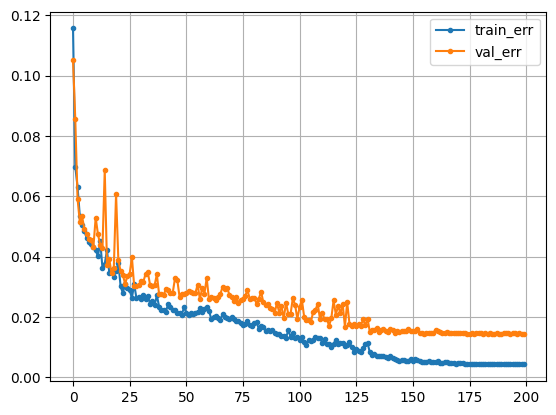

In [11]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

#### 예측 및 평가와 시각화

2/2 [==============================] - 0s 6ms/step
MAE : 228.2668008609694
MAPE: 0.023159566753265148
R2  : 0.993772641714441


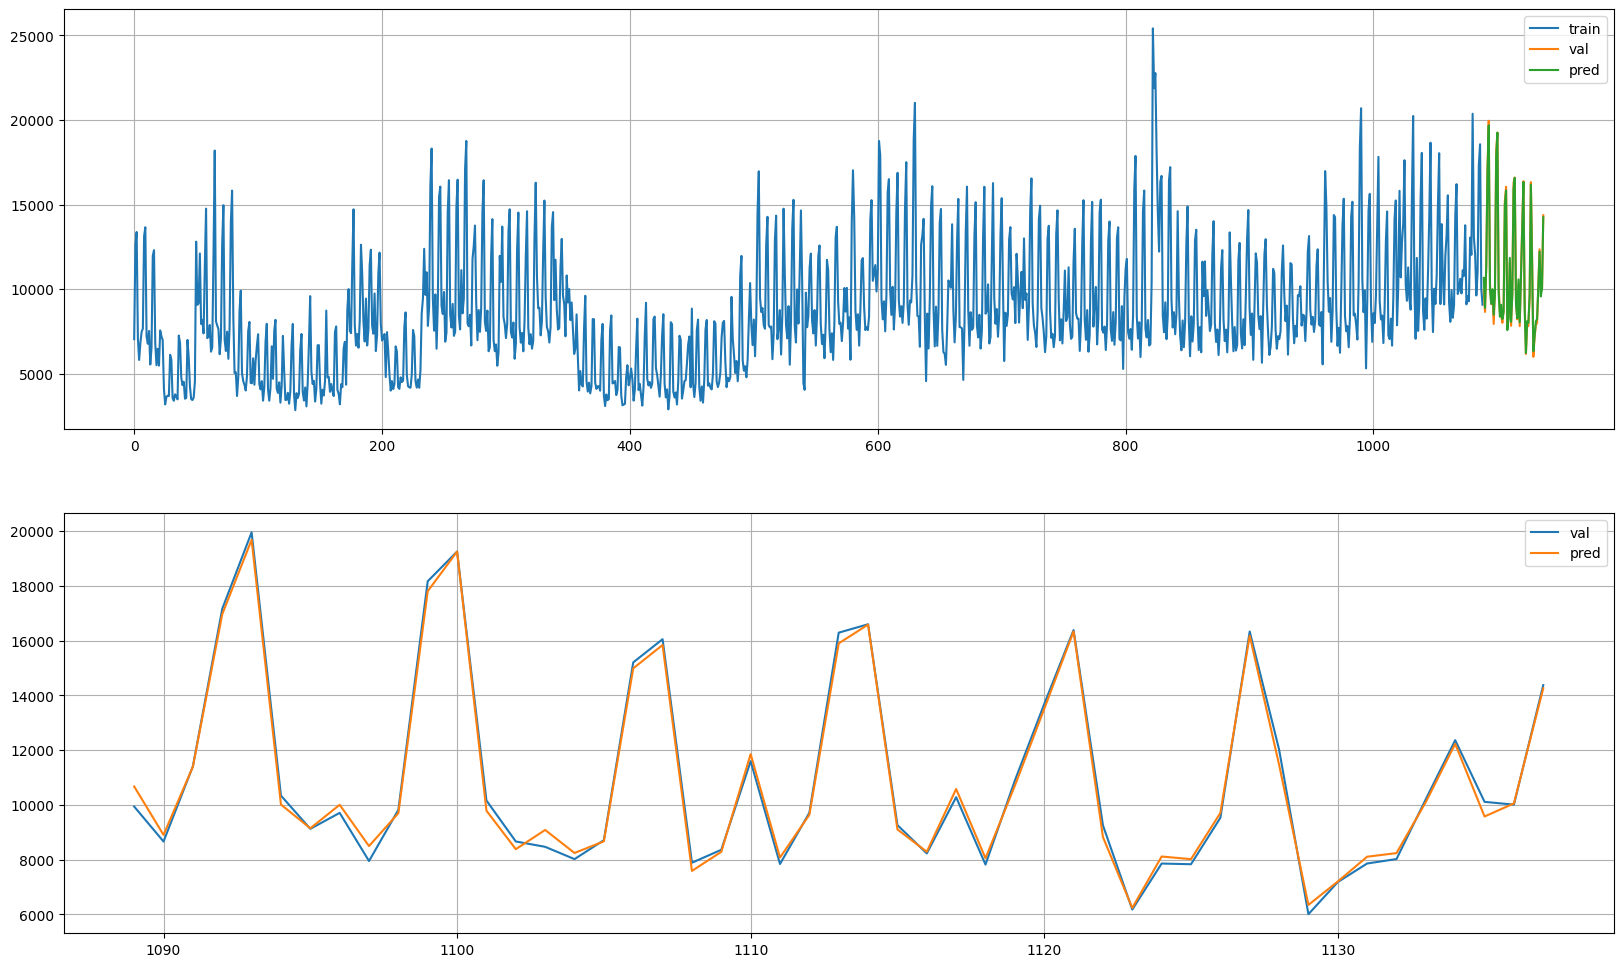

In [12]:
pred = model3_2.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

plot_model_result(y_train, y_val, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [19]:
# product ID : 12
x_train, x_val, y_train, y_val= train_pipline(oil_price, orders, sales, products, stores, 12)
x_train_s3, x_val_s3, y_train_s3, y_val, scaler_x, scaler_y = scaling(x_train, x_val, y_train, y_val)

* **모델링**

In [20]:
n_features = x_train_s3.shape[2]

clear_session()

model12_2 = Sequential([LSTM(16, input_shape = (timesteps, n_features), return_sequences=True),
                     Flatten(),
                     Dense(1)])

model12_2.compile(optimizer = Adam(learning_rate = 0.01), loss='mae')
model12_2.summary()

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=200,  # 개선 없는 epoch 얼마나 기다려 줄거야
                   mode='min',
                   verbose=1,
                   restore_best_weights=True)

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=10,
                                 verbose=1,
                                 factor=0.5, # 0.5를 lr에 곱해주겠다
                                 min_lr=0.000001) # 가장 작은 lr

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 16)             1728      
                                                                 
 flatten (Flatten)           (None, 112)               0         
                                                                 
 dense (Dense)               (None, 1)                 113       
                                                                 
Total params: 1841 (7.19 KB)
Trainable params: 1841 (7.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
hist = model12_2.fit(x_train_s3, y_train_s3, epochs=200, validation_split=.2, callbacks=[es, lr_reduction]).history

Epoch 1/200
28/28 [==============================] - 3s 34ms/step - loss: 0.0783 - val_loss: 0.0596 - lr: 0.0100
Epoch 2/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0464 - val_loss: 0.0490 - lr: 0.0100
Epoch 3/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0449 - lr: 0.0100
Epoch 4/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0404 - val_loss: 0.0422 - lr: 0.0100
Epoch 5/200
28/28 [==============================] - 0s 5ms/step - loss: 0.0392 - val_loss: 0.0427 - lr: 0.0100
Epoch 6/200
28/28 [==============================] - 0s 5ms/step - loss: 0.0420 - val_loss: 0.0444 - lr: 0.0100
Epoch 7/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0372 - val_loss: 0.0390 - lr: 0.0100
Epoch 8/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0380 - val_loss: 0.0405 - lr: 0.0100
Epoch 9/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0365 - val_loss: 0.0398 - lr

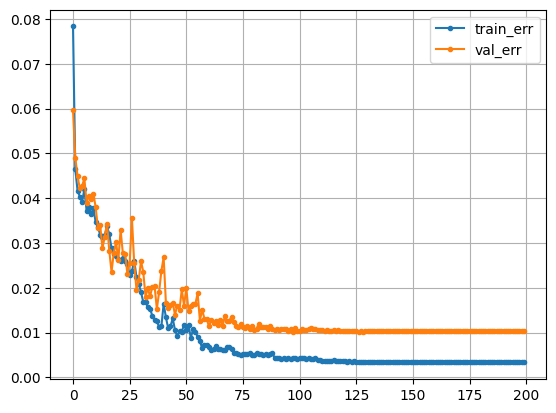

In [22]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

2/2 [==============================] - 0s 7ms/step
MAE : 107.29760243941327
MAPE: 0.010091735680703904
R2  : 0.9978225068453389


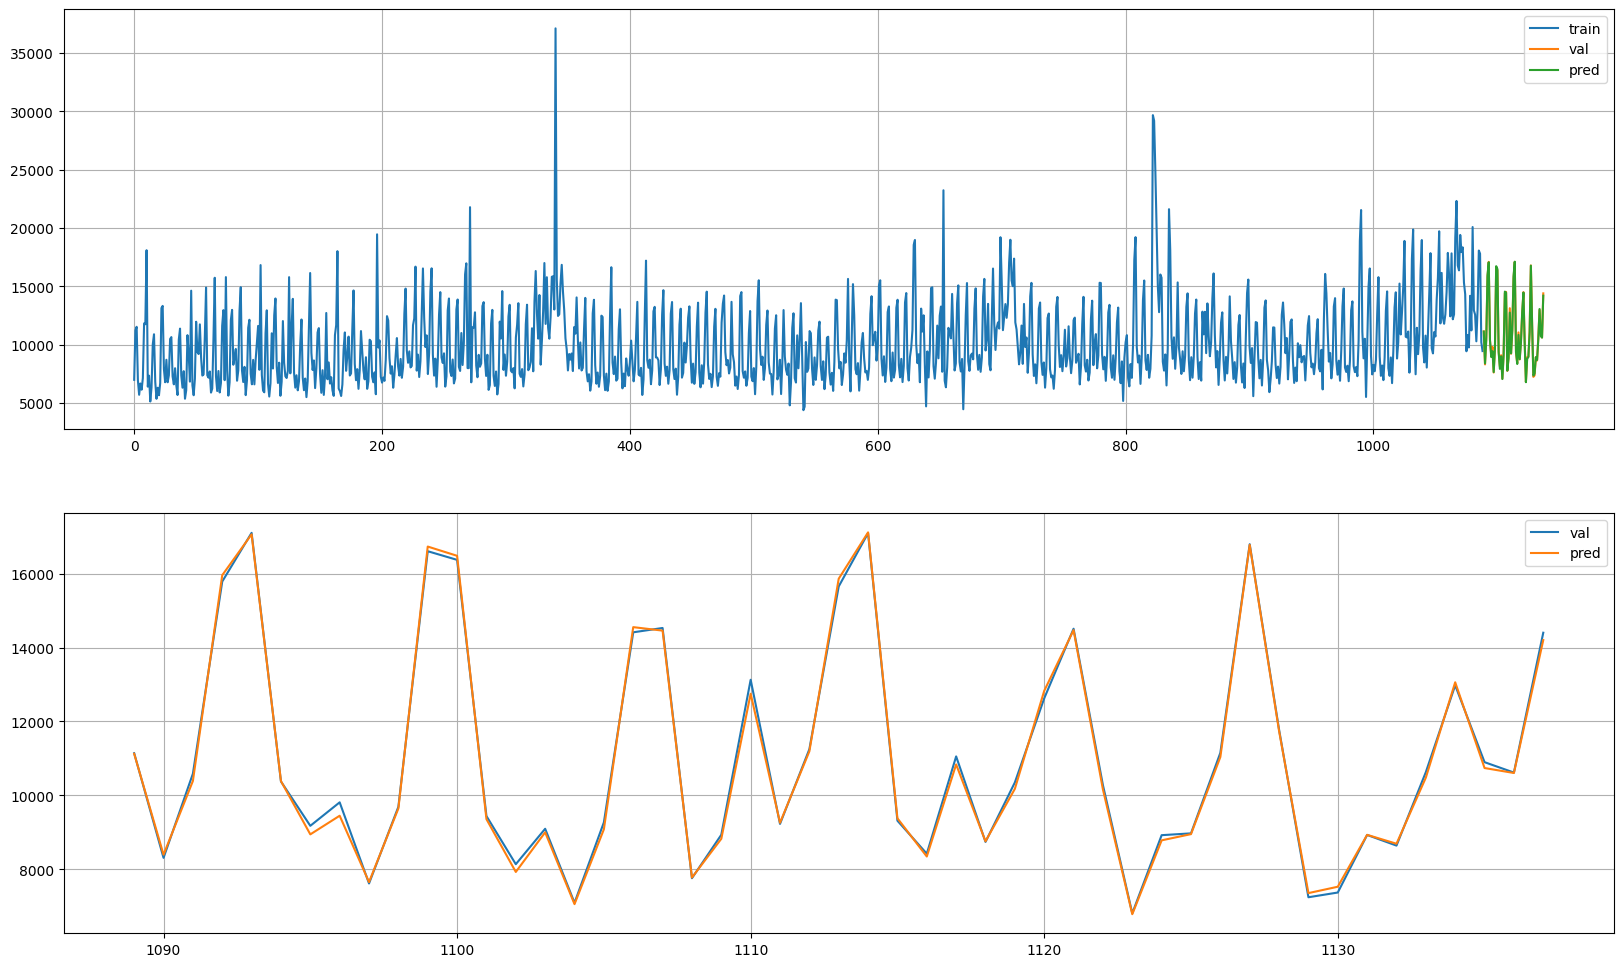

In [23]:
pred = model12_2.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

plot_model_result(y_train, y_val, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [24]:
# product ID : 42
x_train, x_val, y_train, y_val= train_pipline(oil_price, orders, sales, products, stores, 42)
x_train_s3, x_val_s3, y_train_s3, y_val, scaler_x, scaler_y = scaling(x_train, x_val, y_train, y_val)

* **모델링**

In [25]:
n_features = x_train_s3.shape[2]

clear_session()

model42_2 = Sequential([LSTM(16, input_shape = (timesteps, n_features), return_sequences=True),
                     Flatten(),
                     Dense(1)])

model42_2.compile(optimizer = Adam(learning_rate = 0.01), loss='mae')
model42_2.summary()

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=200,  # 개선 없는 epoch 얼마나 기다려 줄거야
                   mode='min',
                   verbose=1,
                   restore_best_weights=True)

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=10,
                                 verbose=1,
                                 factor=0.5, # 0.5를 lr에 곱해주겠다
                                 min_lr=0.000001) # 가장 작은 lr

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 16)             1728      
                                                                 
 flatten (Flatten)           (None, 112)               0         
                                                                 
 dense (Dense)               (None, 1)                 113       
                                                                 
Total params: 1841 (7.19 KB)
Trainable params: 1841 (7.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
hist = model42_2.fit(x_train_s3, y_train_s3, epochs=200, validation_split=.2, callbacks=[es, lr_reduction]).history

Epoch 1/200
28/28 [==============================] - 3s 23ms/step - loss: 0.1605 - val_loss: 0.1088 - lr: 0.0100
Epoch 2/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0868 - val_loss: 0.1009 - lr: 0.0100
Epoch 3/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0718 - val_loss: 0.0836 - lr: 0.0100
Epoch 4/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0688 - val_loss: 0.0757 - lr: 0.0100
Epoch 5/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0640 - val_loss: 0.0741 - lr: 0.0100
Epoch 6/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0686 - val_loss: 0.0874 - lr: 0.0100
Epoch 7/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0664 - val_loss: 0.0925 - lr: 0.0100
Epoch 8/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0641 - val_loss: 0.0672 - lr: 0.0100
Epoch 9/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0678 - val_loss: 0.0923 - lr

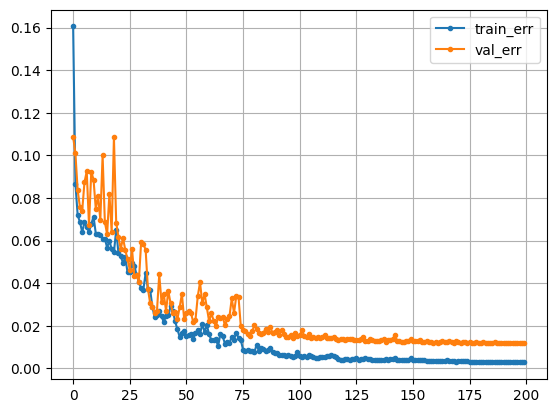

In [27]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

2/2 [==============================] - 0s 9ms/step
MAE : 0.7133102416992188
MAPE: 0.008115313394822004
R2  : 0.9962906251952691


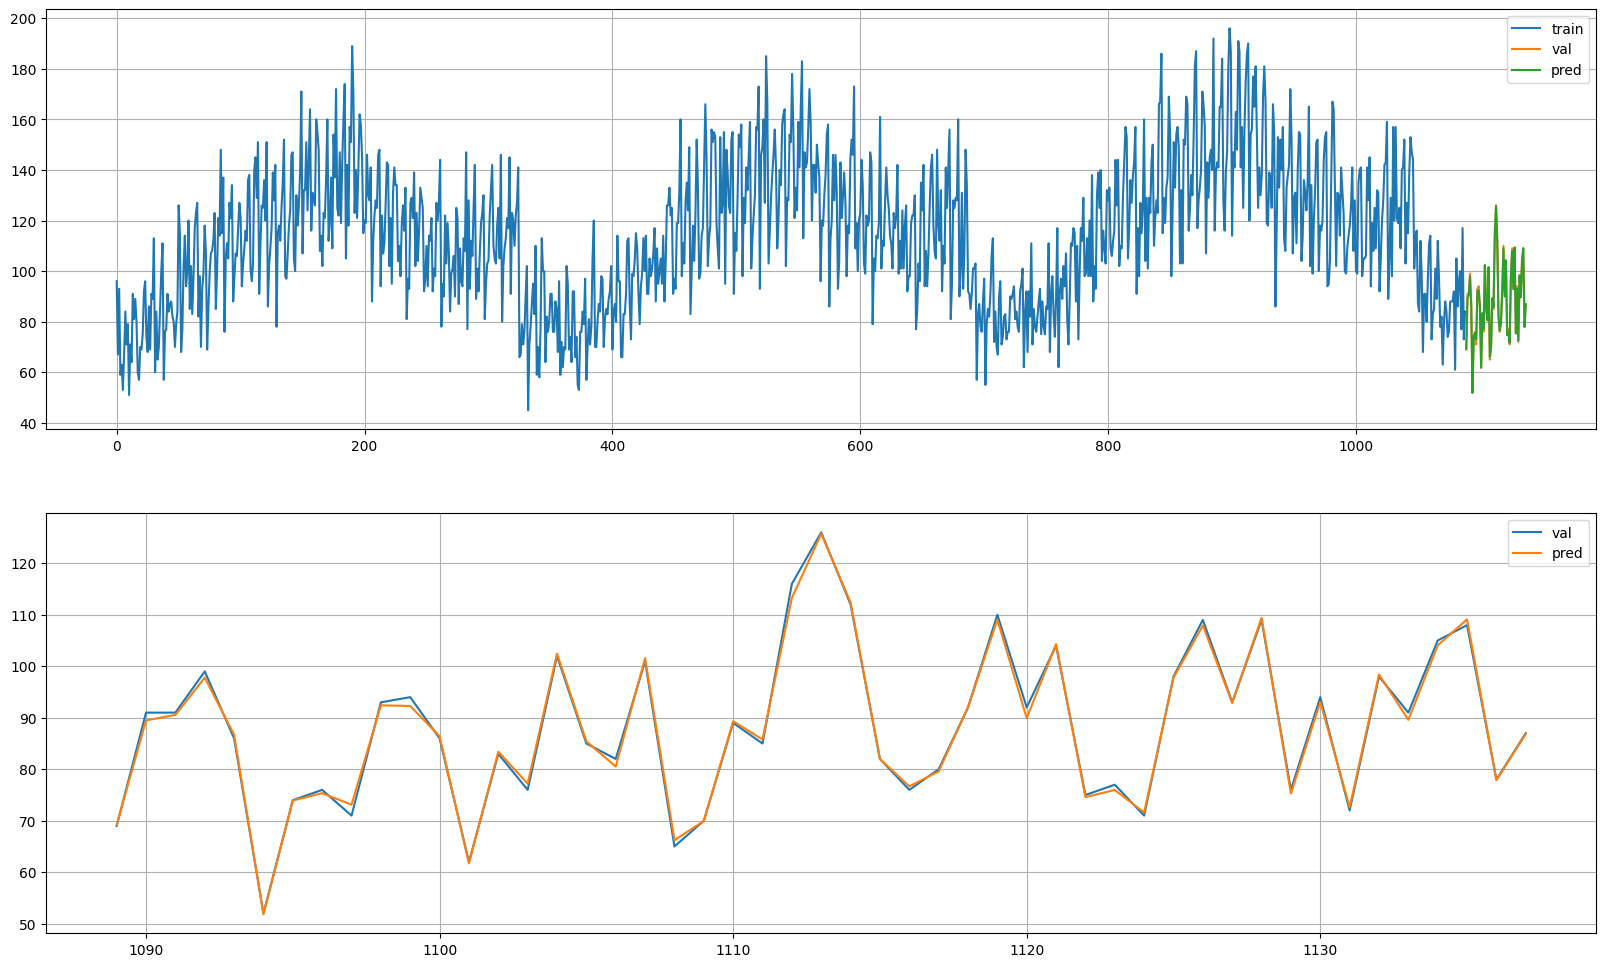

In [28]:
pred = model42_2.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

plot_model_result(y_train, y_val, pred)

## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [29]:
# product ID : 3
x_train, x_val, y_train, y_val= train_pipline(oil_price, orders, sales, products, stores, 3)
x_train_s3, x_val_s3, y_train_s3, y_val, scaler_x, scaler_y = scaling(x_train, x_val, y_train, y_val)

* **모델링**

In [30]:
n_features = x_train.shape[2]

clear_session()

model3_3 = Sequential([Conv1D(16, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                        Flatten(),
                        Dense(1)])

model3_3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mae')

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=20,  # 개선 없는 epoch 얼마나 기다려 줄거야
                   mode='min',
                   verbose=1,
                   restore_best_weights=True)

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=10,
                                 verbose=1,
                                 factor=0.5, # 0.5를 lr에 곱해주겠다
                                 min_lr=0.0000001) # 가장 작은 lr

In [31]:
hist = model3_3.fit(x_train_s3, y_train_s3, epochs=200, validation_split=.2, callbacks=[es, lr_reduction]).history

Epoch 1/200
28/28 [==============================] - 1s 14ms/step - loss: 0.1085 - val_loss: 0.0561 - lr: 0.0100
Epoch 2/200
28/28 [==============================] - 0s 5ms/step - loss: 0.0615 - val_loss: 0.0536 - lr: 0.0100
Epoch 3/200
28/28 [==============================] - 0s 5ms/step - loss: 0.0572 - val_loss: 0.0576 - lr: 0.0100
Epoch 4/200
28/28 [==============================] - 0s 4ms/step - loss: 0.0544 - val_loss: 0.0510 - lr: 0.0100
Epoch 5/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0504 - lr: 0.0100
Epoch 6/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0554 - lr: 0.0100
Epoch 7/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0517 - val_loss: 0.0699 - lr: 0.0100
Epoch 8/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0451 - lr: 0.0100
Epoch 9/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0480 - lr

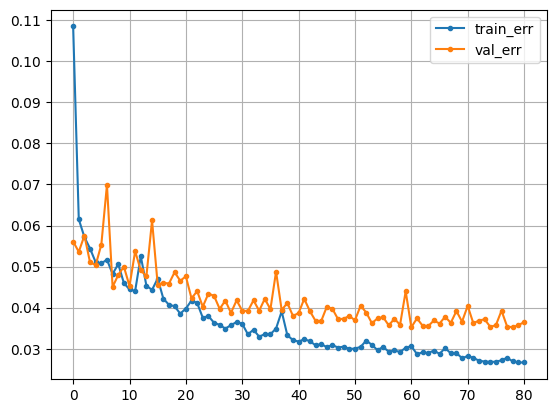

In [32]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

2/2 [==============================] - 0s 5ms/step
MAE : 955.942701690051
MAPE: 0.08238281142090899
R2  : 0.855779632134344


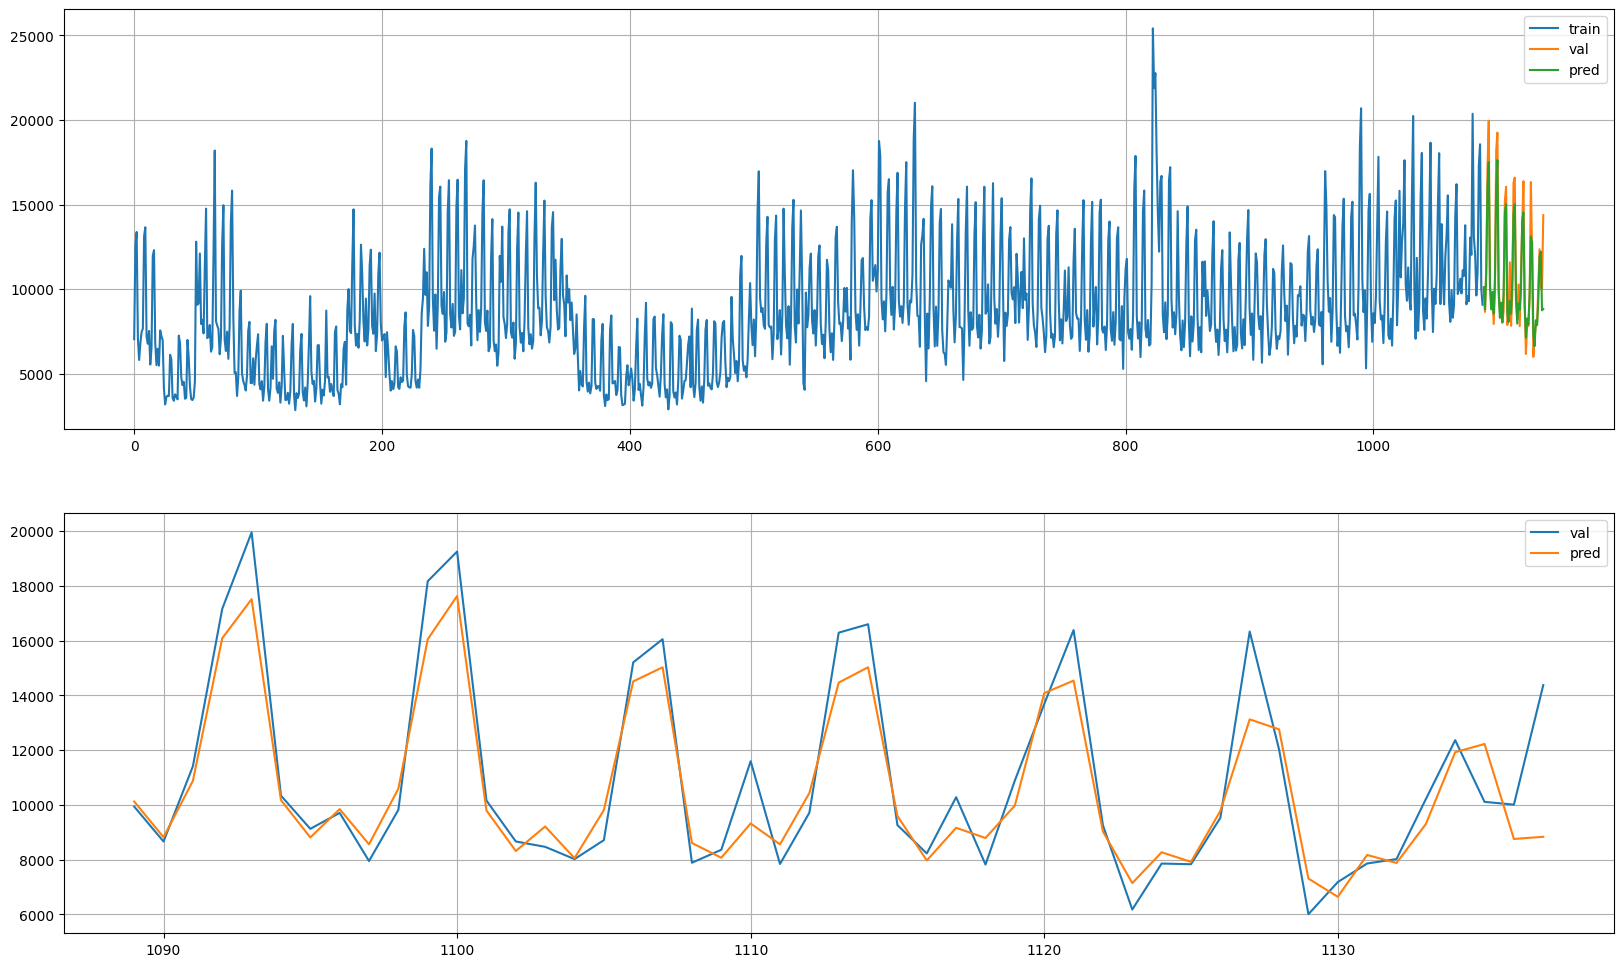

In [33]:
pred = model3_3.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

plot_model_result(y_train, y_val, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [34]:
# product ID : 12
x_train, x_val, y_train, y_val= train_pipline(oil_price, orders, sales, products, stores, 12)
x_train_s3, x_val_s3, y_train_s3, y_val, scaler_x, scaler_y = scaling(x_train, x_val, y_train, y_val)

* **모델링**

In [35]:
n_features = x_train.shape[2]

clear_session()

model12_3 = Sequential([Conv1D(16, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                        Flatten(),
                        Dense(1)])

model12_3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mae')

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=20,  # 개선 없는 epoch 얼마나 기다려 줄거야
                   mode='min',
                   verbose=1,
                   restore_best_weights=True)

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=10,
                                 verbose=1,
                                 factor=0.5, # 0.5를 lr에 곱해주겠다
                                 min_lr=0.0000001) # 가장 작은 lr

In [36]:
hist = model12_3.fit(x_train_s3, y_train_s3, epochs=200, validation_split=.2, callbacks=[es, lr_reduction]).history

Epoch 1/200
28/28 [==============================] - 4s 37ms/step - loss: 0.0990 - val_loss: 0.0642 - lr: 0.0100
Epoch 2/200
28/28 [==============================] - 0s 13ms/step - loss: 0.0509 - val_loss: 0.0483 - lr: 0.0100
Epoch 3/200
28/28 [==============================] - 0s 14ms/step - loss: 0.0442 - val_loss: 0.0451 - lr: 0.0100
Epoch 4/200
28/28 [==============================] - 0s 9ms/step - loss: 0.0429 - val_loss: 0.0644 - lr: 0.0100
Epoch 5/200
28/28 [==============================] - 0s 12ms/step - loss: 0.0438 - val_loss: 0.0561 - lr: 0.0100
Epoch 6/200
28/28 [==============================] - 0s 9ms/step - loss: 0.0387 - val_loss: 0.0425 - lr: 0.0100
Epoch 7/200
28/28 [==============================] - 0s 10ms/step - loss: 0.0365 - val_loss: 0.0436 - lr: 0.0100
Epoch 8/200
28/28 [==============================] - 0s 10ms/step - loss: 0.0379 - val_loss: 0.0435 - lr: 0.0100
Epoch 9/200
28/28 [==============================] - 0s 10ms/step - loss: 0.0354 - val_loss: 0.043

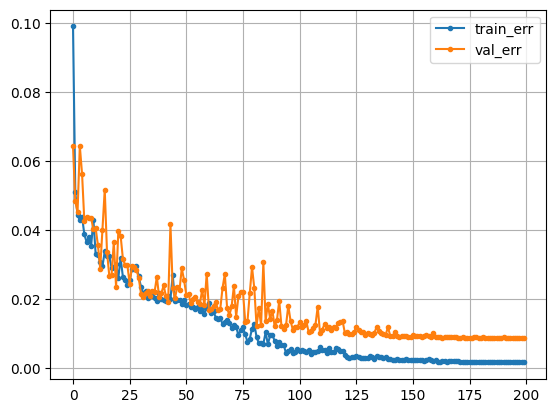

In [37]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

2/2 [==============================] - 0s 5ms/step
MAE : 22.93475964604592
MAPE: 0.0021501463287208586
R2  : 0.9995457052249929


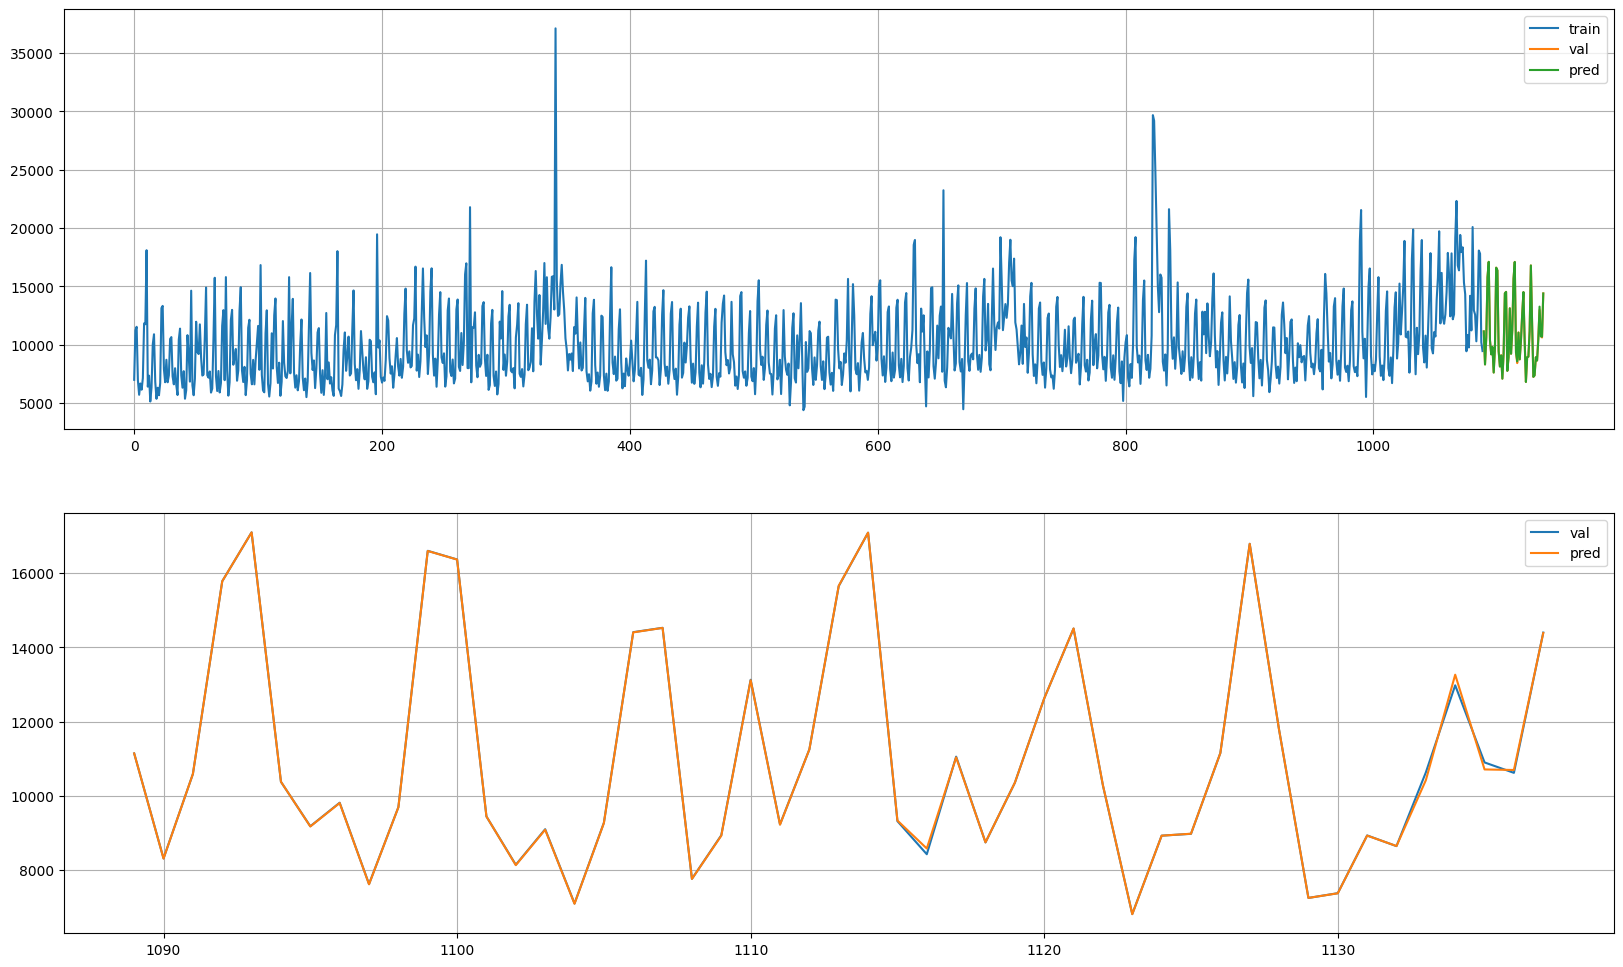

In [38]:
pred = model12_3.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

plot_model_result(y_train, y_val, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [39]:
# product ID : 42
x_train, x_val, y_train, y_val= train_pipline(oil_price, orders, sales, products, stores, 42)
x_train_s3, x_val_s3, y_train_s3, y_val, scaler_x, scaler_y = scaling(x_train, x_val, y_train, y_val)

* **모델링**

In [40]:
n_features = x_train.shape[2]

clear_session()

model42_3 = Sequential([Conv1D(16, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                        Flatten(),
                        Dense(1)])

model42_3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mae')

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=20,  # 개선 없는 epoch 얼마나 기다려 줄거야
                   mode='min',
                   verbose=1,
                   restore_best_weights=True)

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=10,
                                 verbose=1,
                                 factor=0.5, # 0.5를 lr에 곱해주겠다
                                 min_lr=0.0000001) # 가장 작은 lr

In [41]:
hist = model42_3.fit(x_train_s3, y_train_s3, epochs=200, validation_split=.2, callbacks=[es, lr_reduction]).history

Epoch 1/200
28/28 [==============================] - 1s 9ms/step - loss: 0.1195 - val_loss: 0.1523 - lr: 0.0100
Epoch 2/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0811 - val_loss: 0.0735 - lr: 0.0100
Epoch 3/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0695 - val_loss: 0.0765 - lr: 0.0100
Epoch 4/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0692 - val_loss: 0.0940 - lr: 0.0100
Epoch 5/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0702 - val_loss: 0.0764 - lr: 0.0100
Epoch 6/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0611 - val_loss: 0.0708 - lr: 0.0100
Epoch 7/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0621 - val_loss: 0.0925 - lr: 0.0100
Epoch 8/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0708 - val_loss: 0.0718 - lr: 0.0100
Epoch 9/200
28/28 [==============================] - 0s 3ms/step - loss: 0.0663 - val_loss: 0.0895 - lr:

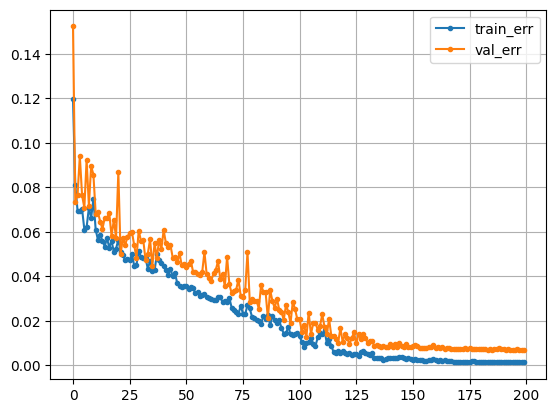

In [42]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

2/2 [==============================] - 0s 4ms/step
MAE : 1.6597672287298708
MAPE: 0.020305546259702698
R2  : 0.9777655867447134


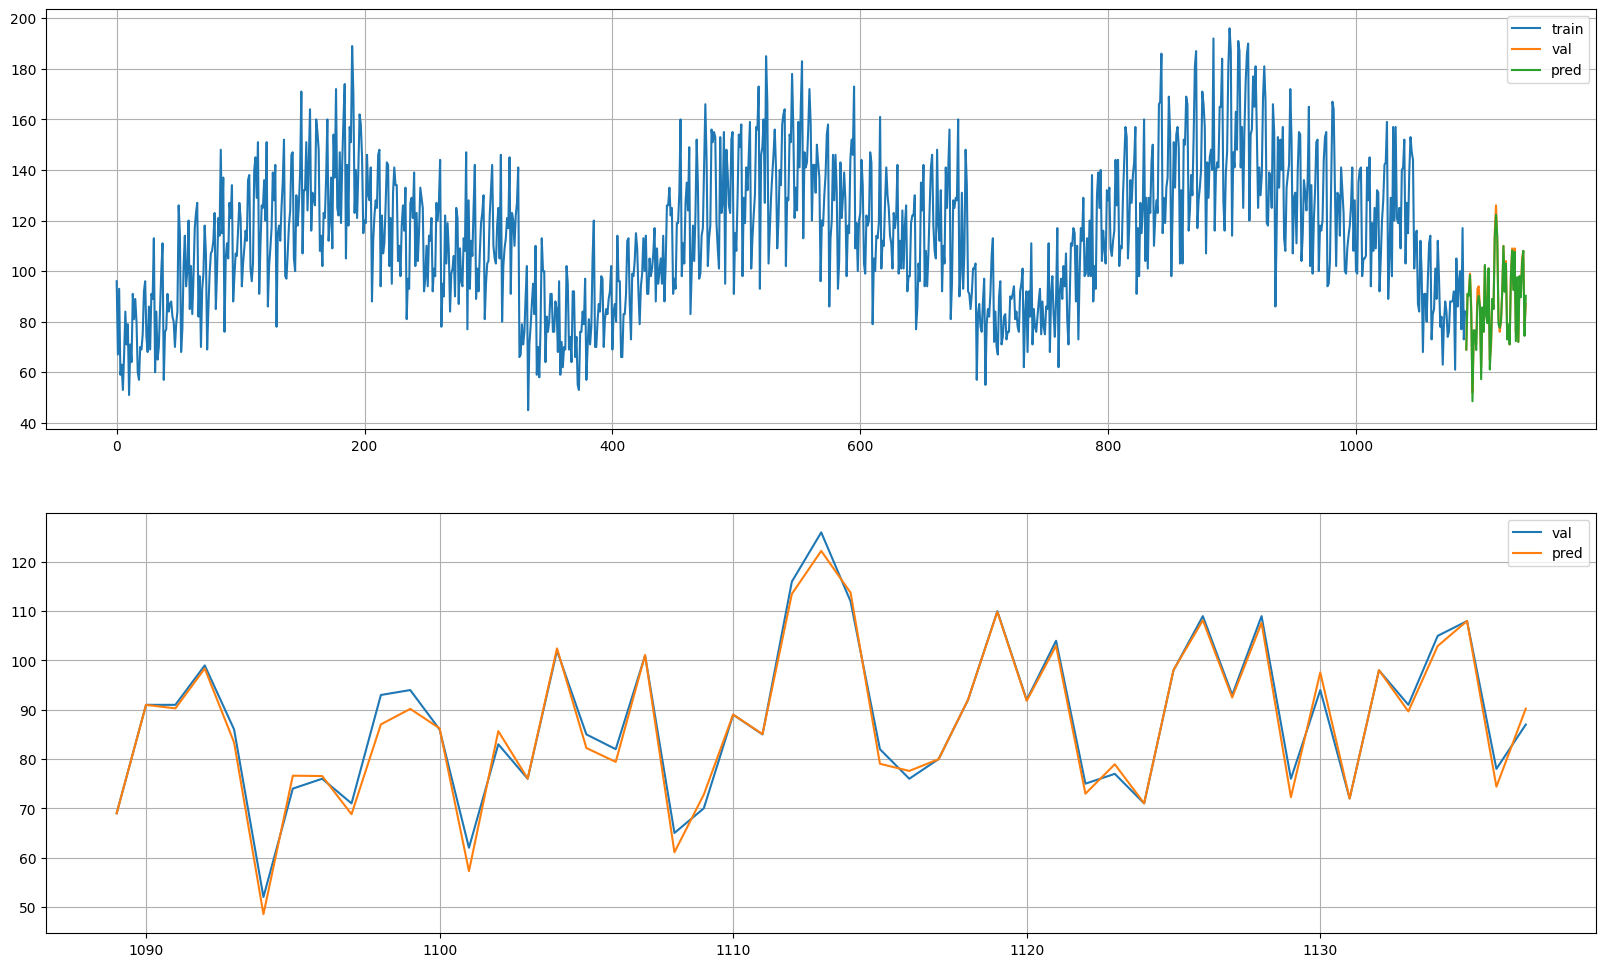

In [43]:
pred = model42_3.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

plot_model_result(y_train, y_val, pred)

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [45]:
def test_pipline(oil_price, orders, sales, products, stores, Product_ID, scaler):

    price = products.loc[products['Product_ID'] == Product_ID, 'Price']
    data = get_dataset(oil_price, orders, sales, products, stores, Product_ID)

    Selected_Features = ['year', 'month', 'week', 'weekday','season','is_weekend','CustomerCount', 'Qty', 'trend', 'seasonal']
    test_data = preprocessing(data, Selected_Features, Store_ID=44, Product_ID=Product_ID)

    target = 'Target_Qty'
    x_test = test_data.drop([target], axis = 1)
    y_test = test_data.loc[:, target]

    timesteps = 7          # 7
    x2_test, y2_test = temporalize(x_test, y_test, timesteps)
    x_test_s3 = scale(x2_test, scaler)

    return x_test_s3, y2_test, price.item()

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [49]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [60]:
x_test_s3, y2_test, price = test_pipline(oil_price_test, orders_test, sales_test, products, stores, 42, scaler_x)

* 예측해보기

1/1 [==============================] - 0s 87ms/step
MAE : 3.247340326723845
MAPE: 0.028674812521317605
R2  : 0.9386114599259507


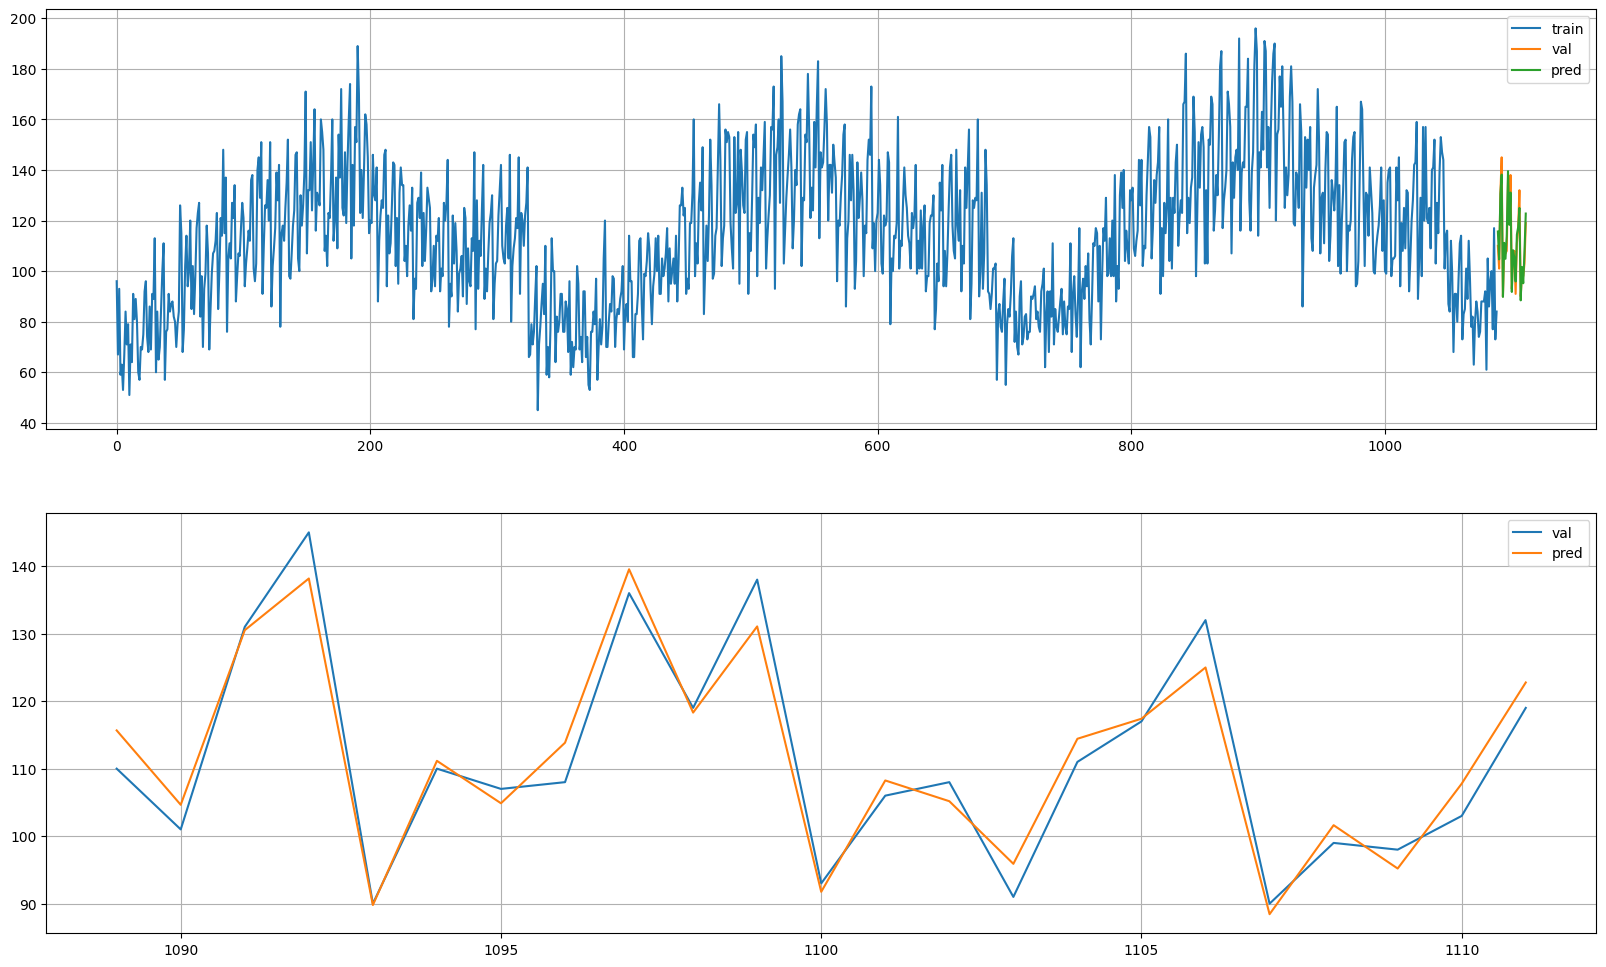

In [61]:
pred = model42_2.predict(x_test_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y2_test, pred))
print('MAPE:', mean_absolute_percentage_error(y2_test, pred))
print('R2  :', r2_score(y2_test, pred))

plot_model_result(y_train, y2_test, pred)

# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [62]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [63]:
inv_simulator(y2_test, pred, 4556, price) # 상품 : 42 / lstm 모델 결과값

일평균 재고량     : 4612.048
일평균 재고 금액  : 23060.239999999998
일평균 재고회전율 : 0.024
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,110.0,116.0,4666,4556,131,110,0.0
1,101.0,105.0,4657,4556,138,101,0.0
2,131.0,131.0,4687,4556,90,131,0.0
3,145.0,138.0,4694,4549,118,138,0.0
4,90.0,90.0,4639,4549,112,90,0.0
5,110.0,111.0,4667,4557,113,118,0.0
6,107.0,105.0,4669,4562,134,112,0.0
7,108.0,114.0,4675,4567,107,113,0.0
8,136.0,140.0,4701,4565,122,134,0.0
9,119.0,118.0,4672,4553,95,107,0.0


In [ ]:
# product : 3 / random_seed = 2014